# Derivatives Analytics - Options Greeks

**Author**: [Gabriele Pompa](https://www.linkedin.com/in/gabrielepompa/): gabriele.pompa@unisi.com

# Table of contents

[Executive Summary](#executive-summary)

1. [Option Greeks](#opt_greeks)\
    1.1. [Numeric Derivatives](#numeric_greeks)\
    1.2. [`NumericGreeks` class](#NumericGreeks_class)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.2.1. [Numeric $\Delta$](#Numeric_Delta)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.2.2. [Numeric $\Theta$](#Numeric_Theta)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.2.3. [Numeric $\Gamma$](#Numeric_Gamma)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.2.4. [Effect of $\epsilon$ reduction](#Numeric_Gamma_epsilon_reduction)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.2.5. [Numeric Vega](#Numeric_Vega)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.2.6. [Numeric $\rho$](#Numeric_Rho)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.2.7. [Put options](#Numeric_greeks_put)\
    1.3. [Analytic Vs Numeric greeks](#Analytic_Vs_Numeric_Greeks)
2. [Implied volatility](#implied_volatility)\
    2.1. [Newton method to find the root of $\sin(x)$ for $x \in [-\frac{\pi}{2}, \frac{\pi}{2}]$](#newton_sin)\
    2.2. [Newton method to find $\sigma_{imp}$](#newton_sigma)

### **Resources**: 

- [_Python for Finance (2nd ed.)_](http://shop.oreilly.com/product/0636920117728.do): Chapter 6 Object-Oriented Programming.

# Executive Summary <a name="executive-summary"></a>

In this notebook we introduce option greeks. That is, the first-order derivatives of an option price with respect to its pricing parameters. We provide both a numeric computation using finite-difference methods implemented in `NumericGreeks` class and their analytic expression under the Black-Scholes models.

The following sections are organized as follows:

- In Sec. [1](#opt_greeks) we introduce `NumericGreeks` class implementing finite-difference methods to compute the main greeks of an `EuropeanOption`. We make also comparisons between the numeric evaluation of greeks and their analytic expression under the Black-Scholes model.
- In Sec. [2](#implied_volatility) we introduce the concept of implied volatility, the Newton root-finding method and the `.implied_volatility()` method that implements it (and Least-Squares constrained method) for an `EuropeanOption`.

All features introduced in this and previous notebooks are collected in `pyBlackScholesAnalytics` Python package.

These are the basic imports

In [1]:
# for NumPy arrays
import numpy as np

# for Pandas Series and DataFrame
import pandas as pd

# for statistical functions
from scipy import stats

# for Matplotlib plotting
import matplotlib.pyplot as plt

# to do inline plots in the Notebook
%matplotlib inline

# for Operating System operations
import os

# for some mathematical functions
import math

# for date management
import datetime as dt

# to identify iterable data-structures
from collections.abc import Iterable

This below is needed to inform the Python interpreter of classes and functions definitions stored in files under pyBlackScholesAnalytics directory.

In [2]:
import os, sys
sys.path.insert(0, os.path.abspath('../pyBlackScholesAnalytics'))

# 1. Option Greeks <a name="opt_greeks"></a>

Consider a plain-vanilla option of strike $K$, expiration date $T$ with pricing function at time $t$

$$
c_t = c(S_t, K, t, T, \sigma, r) 
$$

The greeks of this option are the first-order derivatives w.r.t. its pricing parameters: $S$ (the $\Delta$), $t$ (the $\Theta$), $\sigma$ (the $Vega$) and $r$ (the $\rho$).

We first introduce finite-difference methods to compute them numerically and then compare them with their analytical expression under the Black-Scholes model.

## 1.1. Numeric Derivatives <a name="numeric_greeks"></a>

Let's start with a non-financial example. Let's compute the numeric derivative $f'(x)$ of $f(x)=\sin(x)$ at $x_0=0$. We use finite differences, that is we approximate the exact derivative $f'(x_0)=\cos(x_0)$ with the _central_ finite-difference

$$
f'_{num}(x_0) = \frac{f(x_0 + \epsilon) - f(x_0-\epsilon)}{2 \epsilon} + \mathcal{O}(\epsilon^2)
$$

where $\epsilon$ is a tolerance threshold and the order of the remaining part (that we omit in our approximation) is second-order in $\epsilon$. More on finite-difference methods (which are very general methods) on [Wikipedia](https://en.wikipedia.org/wiki/Finite_difference) (or [this post](http://www.math.unl.edu/~s-bbockel1/833-notes/node23.html)).

In [3]:
from utils.utils import plot_compare

In [4]:
x = np.linspace(0, 2*math.pi, 100)

In [5]:
def df_dx(f, x0, eps):
    return (f(x0 + eps) - f(x0 - eps))/(2*eps)

In [6]:
# numeric derivative of sin(x)
f_num_deriv = df_dx(f=np.sin, x0=x, eps=1e-10)

# exact derivative of sin(x): cos(x)
f_exact_deriv = np.cos(x)

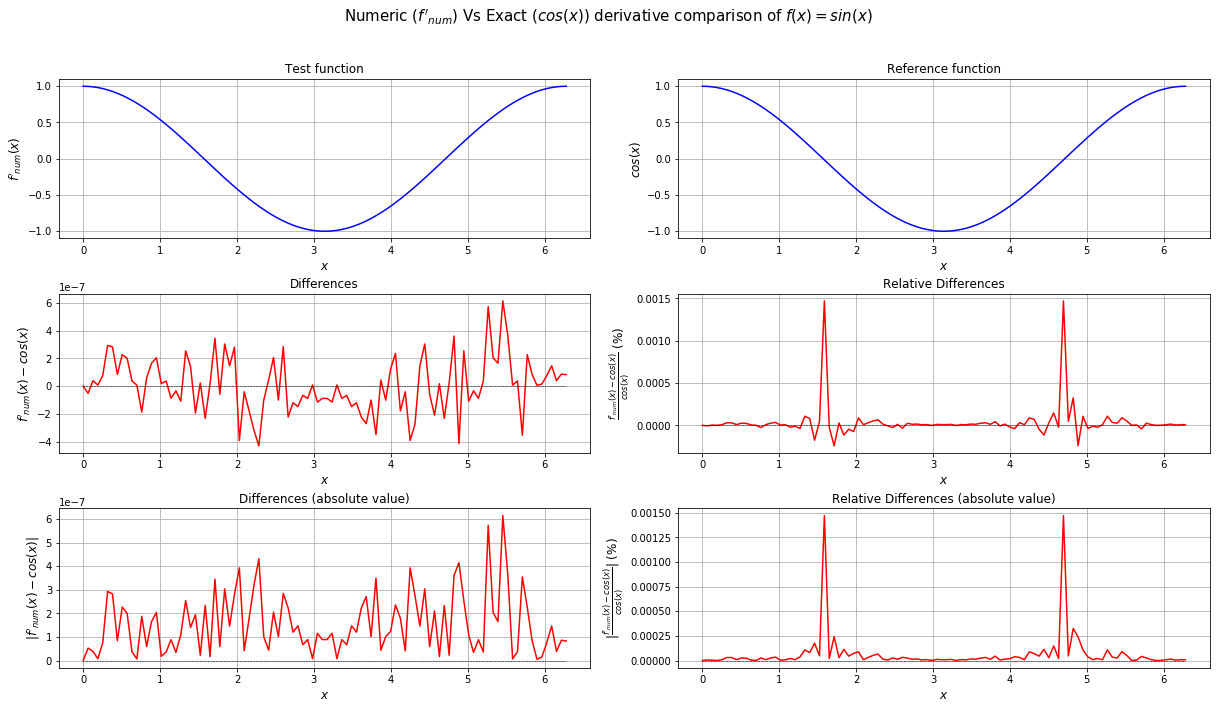

In [7]:
plot_compare(x, f=f_num_deriv, f_ref=f_exact_deriv, 
             f_label=r"f'_{num}(x)", f_ref_label=r"cos(x)",
             title=r"Numeric ($f'_{num}$) Vs Exact ($cos(x)$) derivative comparison of $f(x)=sin(x)$")

## 1.2. `NumericGreeks` class <a name="NumericGreeks_class"></a>

Let's go back to our options world and use finite-differences methods to compute the numeric derivatives of a plain-vanilla call option.

In [8]:
from market.market import MarketEnvironment

In [9]:
mkt_env = MarketEnvironment()

Initializing the MarketEnvironment!


In [10]:
from options.options import PlainVanillaOption

In [11]:
Vanilla_Call = PlainVanillaOption(mkt_env)

Initializing the EuropeanOption!


In [12]:
common_title_Call = Vanilla_Call.get_info() + "\n" + "Market at emission: " + Vanilla_Call.get_mkt_info()

This has been implemented in the `NumericGreeks` class.

In [13]:
from utils.numeric_routines import NumericGreeks

In [14]:
NumGreeks = NumericGreeks(Vanilla_Call)

In [15]:
S_min = 50
S_max = 150
num_S = 2000
S = np.linspace(S_min, S_max, num_S)

### 1.2.1. Numeric $\Delta$ <a name="Numeric_Delta"></a>

$\Delta$ is the derivative w.r.t. to underlying level $S$

In [16]:
delta_numeric = NumGreeks.delta(S=S)

In [17]:
from utils.utils import plot

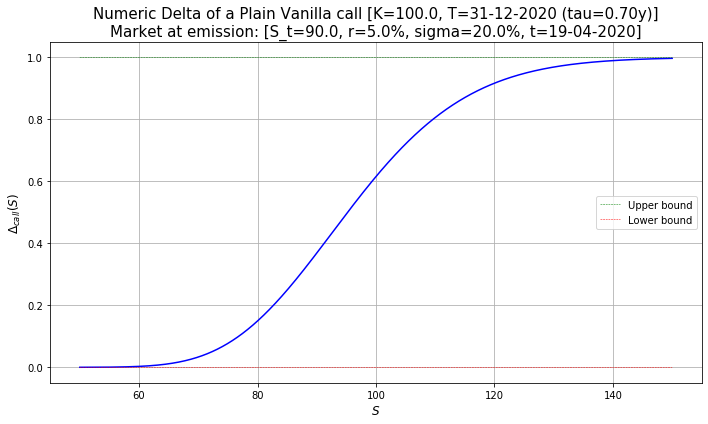

In [18]:
plot(x=S, f=delta_numeric, x_label=r"$S$", f_label=r"$\Delta_{call}(S)$", 
     f_up=np.ones(num_S), f_up_label=r"Upper bound",
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Delta of a " + common_title_Call)

### 1.2.2. Numeric $\Theta$ <a name="Numeric_Theta"></a>

$\Theta$ is the derivative w.r.t. to time $t$

In [19]:
theta_numeric = NumGreeks.theta(S=S)

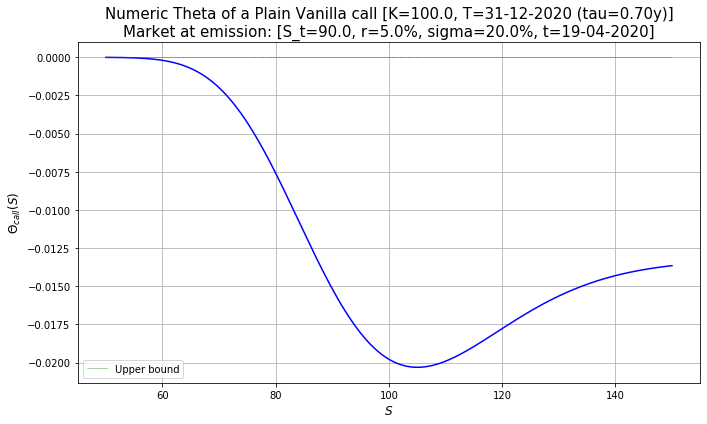

In [20]:
plot(x=S, f=theta_numeric, x_label=r"$S$", f_label=r"$\Theta_{call}(S)$",
     f_up=np.zeros(num_S), f_up_label=r"Upper bound",
     title=r"Numeric Theta of a " + common_title_Call)

### 1.2.3. Numeric $\Gamma$ <a name="Numeric_Gamma"></a>

$\Gamma$ is the second derivative w.r.t. to underlying level $S$. Being a second-order derivative, its finite-difference approximation is the following (omitting other pricing parameters)

$$
\Gamma_{num}(...,S_0) = \frac{c(...,S_0 - \epsilon) - 2 c(...,S_0) + c(...,S_0 + \epsilon) }{\epsilon^2} + \mathcal{O}(\epsilon^2)
$$


In [21]:
gamma_numeric = NumGreeks.gamma(S=S)

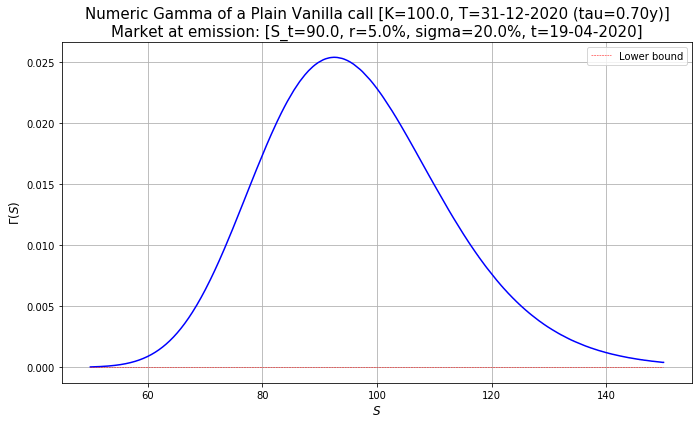

In [22]:
plot(x=S, f=gamma_numeric, x_label=r"$S$", f_label=r"$\Gamma(S)$",
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Gamma of a " + common_title_Call)

### 1.2.4. Effect of $\epsilon$ reduction <a name="Numeric_Gamma_epsilon_reduction"></a>

Reducing $\epsilon$ does not guarantee increased accuracy. On the contrary, it can severely decrease the stability and overall quality of numeric approximation. Let's consider this effect on the $\Gamma$ greek.

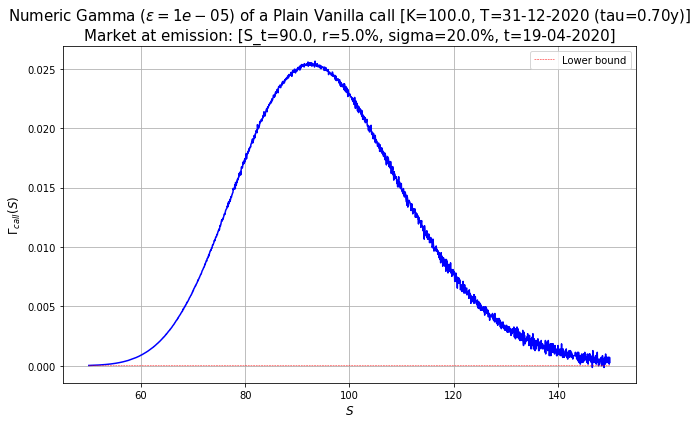

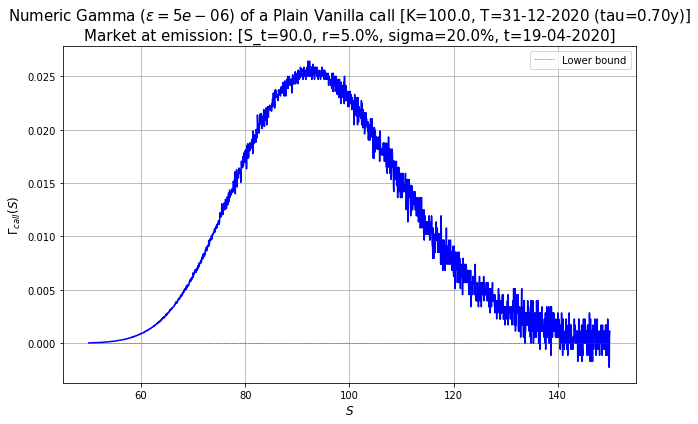

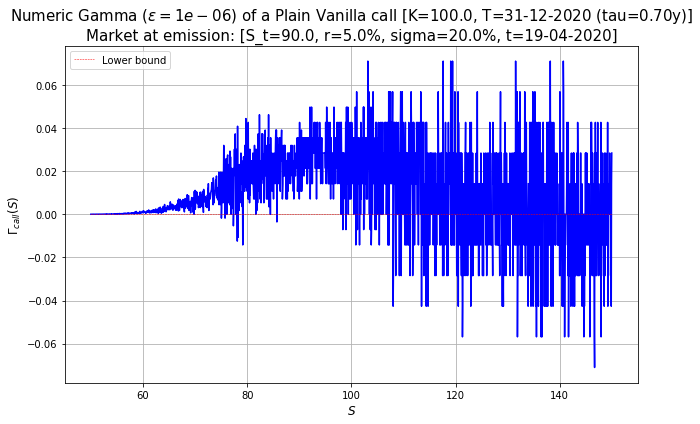

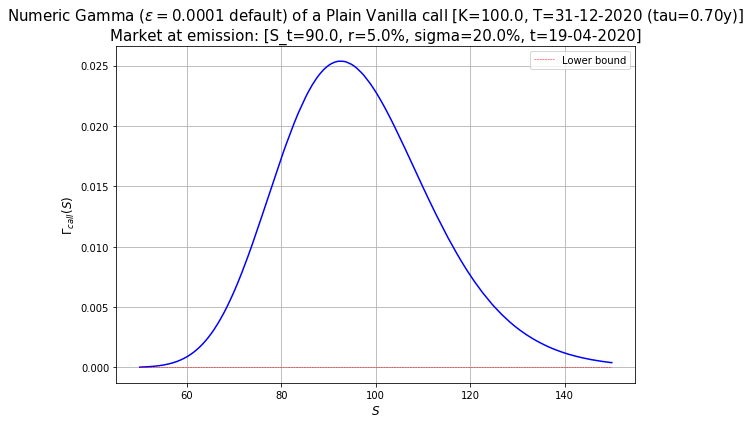

In [23]:
# epsilon reduction: 1e-4 --> 1e-5
NumGreeks.set_epsilon(1e-5)

# numeric gamma
gamma_numeric = NumGreeks.gamma(S=S)

# gamma plot
plot(x=S, f=gamma_numeric, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Gamma ($\epsilon={}$) of a ".format(NumGreeks.get_epsilon()) + common_title_Call)

# epsilon further reduction: 1e-5 --> 5e-6
NumGreeks.set_epsilon(5e-6)

# numeric gamma
gamma_numeric = NumGreeks.gamma(S=S)

# gamma plot
plot(x=S, f=gamma_numeric, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Gamma ($\epsilon={}$) of a ".format(NumGreeks.get_epsilon()) + common_title_Call)

# epsilon even further reduction: 1e-5 --> 1e-6
NumGreeks.set_epsilon(1e-6)

# numeric gamma
gamma_numeric = NumGreeks.gamma(S=S)

# gamma plot
plot(x=S, f=gamma_numeric, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Gamma ($\epsilon={}$) of a ".format(NumGreeks.get_epsilon()) + common_title_Call)

# restoring default value of epsilon
NumGreeks.set_epsilon()

# numeric gamma
gamma_numeric = NumGreeks.gamma(S=S)

# gamma plot
plot(x=S, f=gamma_numeric, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Gamma ($\epsilon={}$ default) of a ".format(NumGreeks.get_epsilon()) + common_title_Call)

### 1.2.5. Numeric Vega <a name="Numeric_Vega"></a>

$Vega$ is the derivative w.r.t. to underlying volatility $\sigma$

In [24]:
vega_numeric = NumGreeks.vega(S=S)

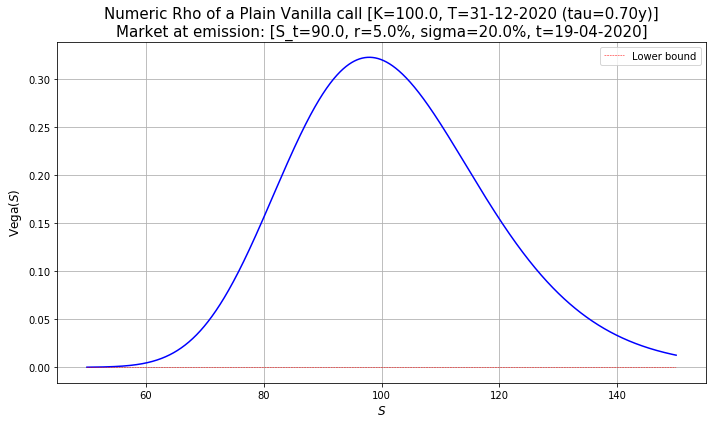

In [25]:
plot(x=S, f=vega_numeric, x_label=r"$S$", f_label=r"Vega$(S)$", 
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Rho of a " + common_title_Call)

### 1.2.6. Numeric $\rho$ <a name="Numeric_Rho"></a>

$\rho$ is the derivative w.r.t. to short-rate level $r$

In [26]:
rho_numeric = NumGreeks.rho(S=S)

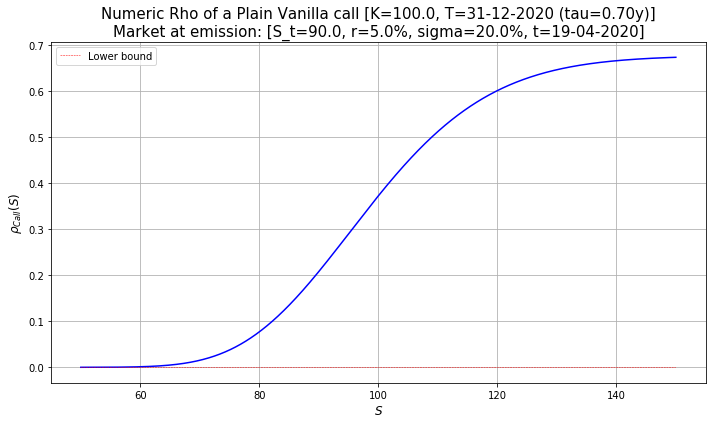

In [27]:
plot(x=S, f=rho_numeric, x_label=r"$S$", f_label=r"$\rho_{Call}(S)$", 
     f_down=np.zeros(num_S), f_down_label=r"Lower bound",
     title=r"Numeric Rho of a " + common_title_Call)

### 1.2.7. Put options <a name="Numeric_greeks_put"></a>

Let's make an example using a `Vanilla_Put` option

In [28]:
Vanilla_Put = PlainVanillaOption(mkt_env, option_type="put")

Initializing the EuropeanOption!


In [29]:
common_title_Put = Vanilla_Put.get_info() + "\n" + "Market at emission: " + Vanilla_Call.get_mkt_info()

In [30]:
NumGreeks = NumericGreeks(Vanilla_Put)

In [31]:
delta_numeric = NumGreeks.delta(S=S)

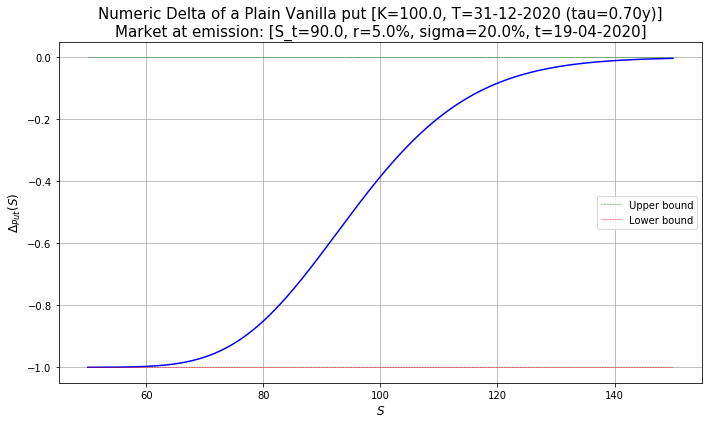

In [32]:
plot(x=S, f=delta_numeric, x_label=r"$S$", f_label=r"$\Delta_{Put}(S)$", 
     f_up=np.zeros(len(S)), f_up_label=r"Upper bound",
     f_down=-np.ones(len(S)), f_down_label=r"Lower bound",
     title=r"Numeric Delta of a " + common_title_Put)

## 1.3. Analytic Vs Numeric greeks <a name="Analytic_Vs_Numeric_Greeks"></a>

Under the Black-Scholes model, analytical expressions for greeks of plain-vanilla (as well as for digital) options are available. We have implemented them in `PlainVanillaOption` and `DigitalOption` classes, respectively. It's interesting to compare the numeric and analytical implementation of the same greek, to better appreciate the numerical error.

In [33]:
NumGreeks = NumericGreeks(Vanilla_Call)

Let's define a simple utility function to better display plot titles

In [34]:
def greeks_title_factory(ObjWithGreeksMethod, greek_type, underlying="S"):

    # plot common title
    common_title = ObjWithGreeksMethod.get_info() + "\n" + "Market at emission: " + ObjWithGreeksMethod.get_mkt_info()

    title_dispatcher = {"delta": r"$\Delta(" + underlying + ")$",
                         "theta": r"$\Theta(" + underlying + ")$",
                         "gamma": r"$\Gamma(" + underlying + ")$",
                         "vega":  r"$Vega(" + underlying + ")$",
                         "rho":  r"$\rho(" + underlying + ")$",
    }

    # plot title
    plot_title = r"Comparison of Numeric and Exact " + greek_type + " " + title_dispatcher[greek_type] + " Vs $" + underlying + "$ for a \n" + common_title
    
    return plot_title

Comparison of $\Delta$:

In [35]:
delta_analytic = Vanilla_Call.delta(S=S)

In [36]:
delta_numeric = NumGreeks.delta(S=S)

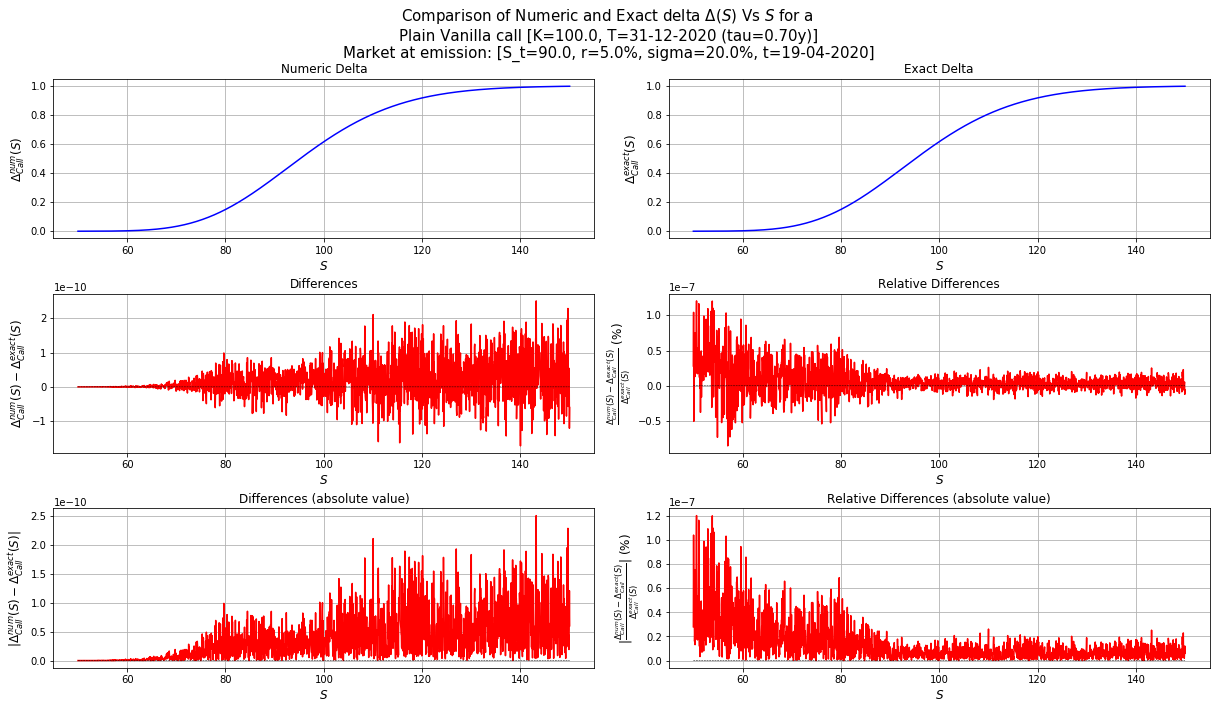

In [37]:
plot_title = greeks_title_factory(Vanilla_Call, "delta")

plot_compare(S, f=delta_numeric, f_ref=delta_analytic, 
             f_label=r"\Delta^{num}_{Call}(S)", f_ref_label=r"\Delta^{exact}_{Call}(S)",
             x_label="S",f_test_name="Numeric Delta",
             f_ref_name="Exact Delta", title=plot_title)

Comparison of theta:

In [38]:
theta_analytic = Vanilla_Call.theta(S=S)

In [39]:
theta_numeric = NumGreeks.theta(S=S)

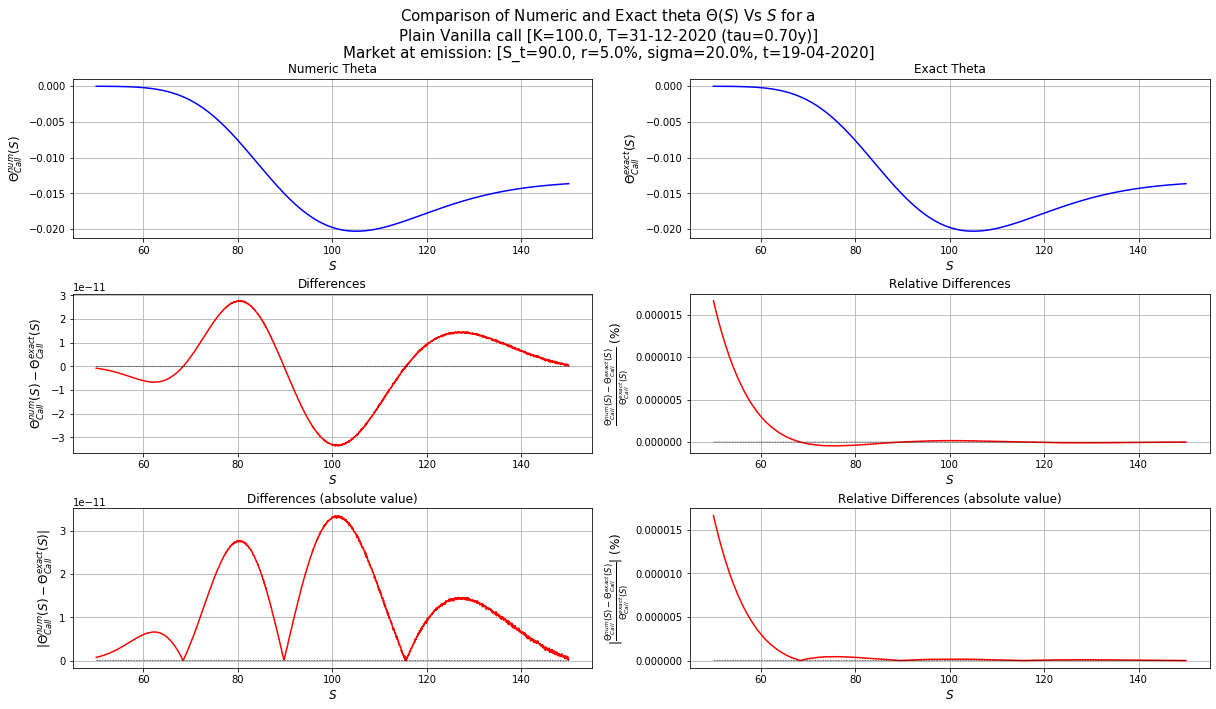

In [40]:
plot_title = greeks_title_factory(Vanilla_Call, "theta")

plot_compare(S, f=theta_numeric, f_ref=theta_analytic, 
             f_label=r"\Theta^{num}_{Call}(S)", f_ref_label=r"\Theta^{exact}_{Call}(S)",
             x_label="S",f_test_name="Numeric Theta",
             f_ref_name="Exact Theta", title=plot_title)

Comparison of gamma:

In [41]:
gamma_analytic = Vanilla_Call.gamma(S=S)

In [42]:
gamma_numeric = NumGreeks.gamma(S=S)

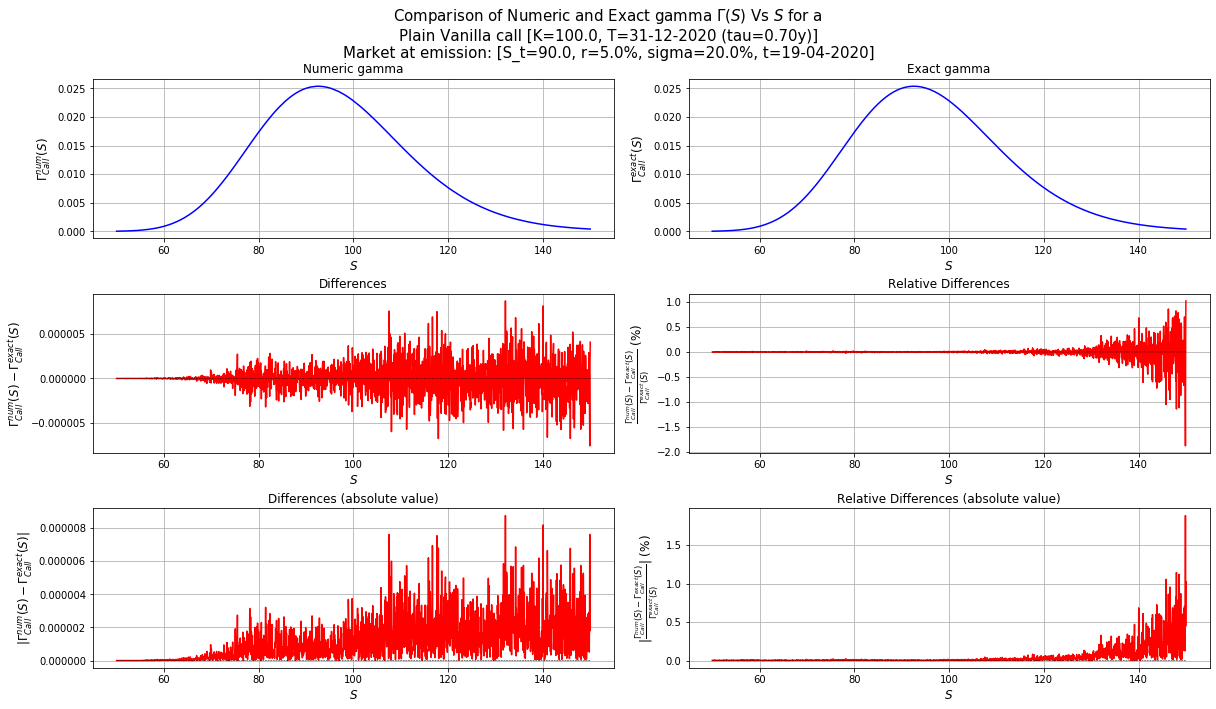

In [43]:
plot_title = greeks_title_factory(Vanilla_Call, "gamma")

plot_compare(S, f=gamma_numeric, f_ref=gamma_analytic, 
             f_label=r"\Gamma^{num}_{Call}(S)", f_ref_label=r"\Gamma^{exact}_{Call}(S)",
             x_label="S",f_test_name="Numeric gamma",
             f_ref_name="Exact gamma", title=plot_title)

Comparison of vega:

In [44]:
vega_analytic = Vanilla_Call.vega(S=S)

In [45]:
vega_numeric = NumGreeks.vega(S=S)

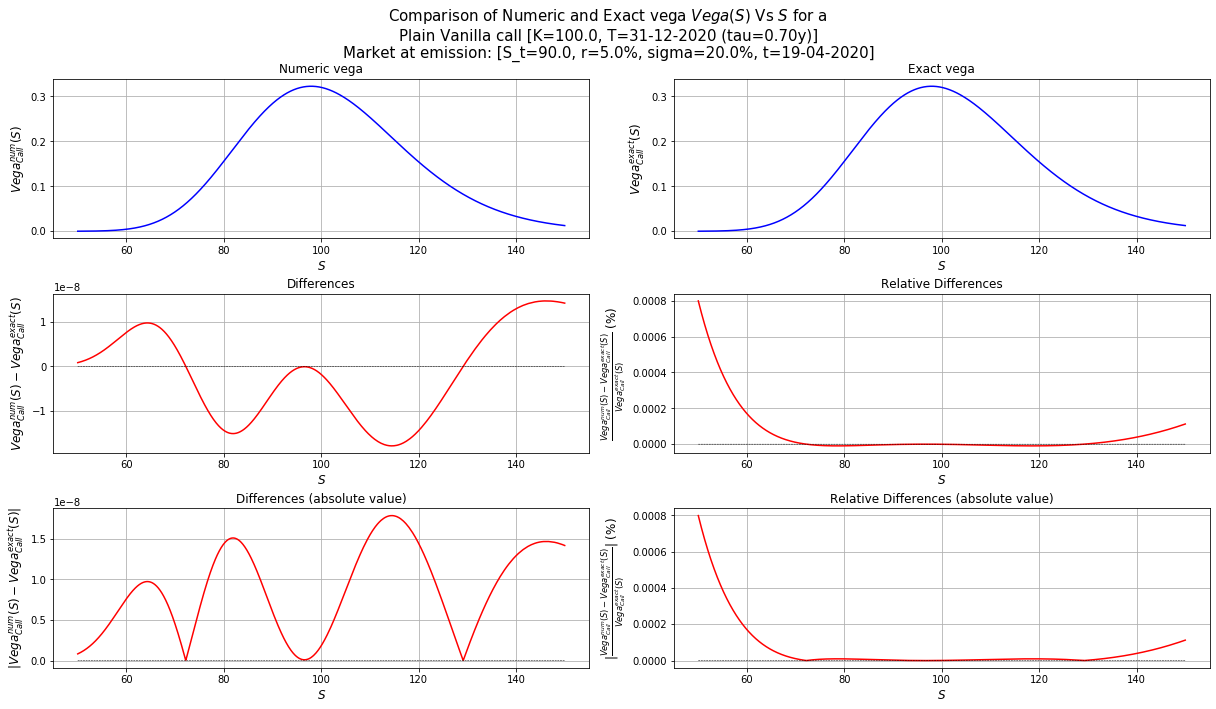

In [46]:
plot_title = greeks_title_factory(Vanilla_Call, "vega")

plot_compare(S, f=vega_numeric, f_ref=vega_analytic, 
             f_label=r"Vega^{num}_{Call}(S)", f_ref_label=r"Vega^{exact}_{Call}(S)",
             x_label="S",f_test_name="Numeric vega",
             f_ref_name="Exact vega", title=plot_title)

Comparison of rho:

In [47]:
rho_analytic = Vanilla_Call.rho(S=S)

In [48]:
rho_numeric = NumGreeks.rho(S=S)

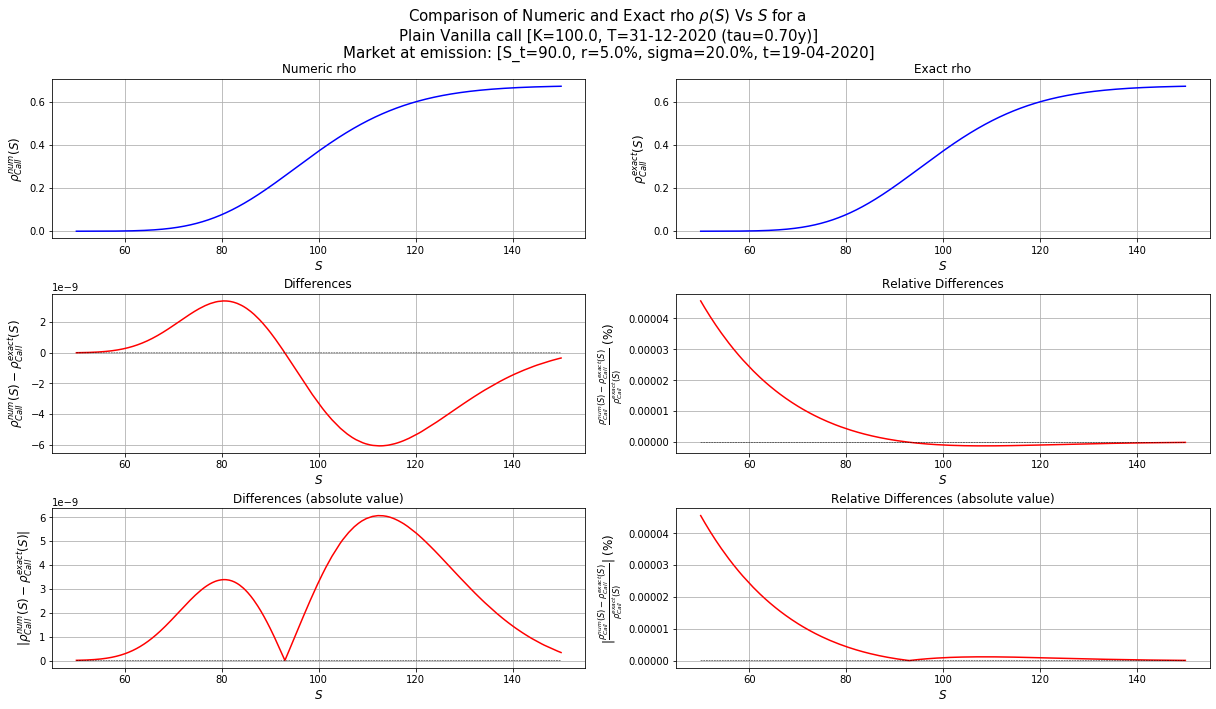

In [49]:
plot_title = greeks_title_factory(Vanilla_Call, "rho")

plot_compare(S, f=rho_numeric, f_ref=rho_analytic, 
             f_label=r"\rho^{num}_{Call}(S)", f_ref_label=r"\rho^{exact}_{Call}(S)",
             x_label="S",f_test_name="Numeric rho",
             f_ref_name="Exact rho", title=plot_title)

# 2. Implied volatility <a name="implied_volatility"></a>

Black-Scholes implied volatility $\sigma_{imp}$ of an option is that value of the underlying asset volatility $\sigma$ such that the Black-Scholes price of the option matches a target price $c_{*}$ (typically either coming from a market quote for the same option or from another model used to evaluate it). That is $\sigma_{imp}$ is the solution of the equation:

$$
c(S_t, K, t, T, \sigma, r) = c_{*}
$$

where $c(S_t, K, t, T, \sigma, r)$ is the Black-Scholes price of an option of strike $K$ and expiratio $T$ at time $t$.
This parameter is what is tipically quoted for options (instead of prices) and is, therefore, fundamental. Its centrality has lead to the development of very sofisticated root-finding methods. We'll start our exploration of implied volatility using the simplest one: the Newton method that we now introduce.

## 2.1. Newton method to find the root of $\sin(x)$ for $x \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ <a name="newton_sin"></a>

Let's quickly refresh Newton method. It is a numerical method to find roots of a function $f(x)$ through an iterative procedure. The goal then is to find a solution for $f(x)=0$. Given the n-th approximating root $x_n$, the subsequent is found as

$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$

that is, it uses the old approximation $x_n$, the function $f$ evaluated at $x_n$ as well as its first-derivative $f'$ with respect to $x$ evaluated at $x_n$. Typically, a stopping criterion involving differences between subsequent approximations 

$$
|x_{n+1} - x_{n}| < \epsilon
$$

or relative differences 

$$
\frac{|x_{n+1} - x_{n}|}{|x_{n}|} < \epsilon
$$

is used.

Start from [Wikipedia](https://en.wikipedia.org/wiki/Newton%27s_method) if you never heard about this fundamental method.

Let's see an example, trying to find a solution for the equation $\sin(x) = 0$ for $x \in [-\frac{\pi}{2}, \frac{\pi}{2}]$.

In [50]:
# setting tolerance
epsilon = 1e-8

# stopping criterion initialization
relative_diff = epsilon + 1

# additionally, we set a maximum number of iterations allowed
max_iter = 100
iter_num = 1

# initial guess for the solution: must be not 'too far' from the solution... 
# because Newton method is a 'local' minimization method

# initialize approximation to an initial guess
x_np1 = 1.0 # x_{n+1}

while (relative_diff > epsilon) and (iter_num <= max_iter):
        
    # updated last solution found: x_n <-- x_{n+1}
    x_n = x_np1
    
    # function to minimize at last solution found
    f_n = np.sin(x_n)
    
    # derivative w.r.t. to x at last solution found
    df_div_n = np.cos(x_n)
    
    # new solution found
    x_np1 = x_n - f_n/df_div_n
    
    # calculation of new value for stopping metrics
    relative_diff = abs((x_np1 - x_n)/x_n)
    
    # iteration counter update
    iter_num += 1

C:\Users\gabri\Anaconda3\envs\ITForBusAndFin2020_env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Here is the solution found (should be $x=0$ of course)

In [51]:
x_np1

0.0

In [52]:
np.sin(x_np1)

0.0

And the solution has been found in 7 iterations (very quick!)

In [53]:
iter_num

7

## 2.2. Newton method to find $\sigma_{imp}$ <a name="newton_sigma"></a>

We now specialize the Newton method to find the implied volatility of the option. The iterative updating procedure becomes

$$
\sigma_{n+1} = \sigma_n - \frac{c(...,\sigma_n) - c_{*}}{Vega(..., \sigma_n)}
$$

where we have considered that 

$$
\frac{\partial c(...,\sigma) - c_{*}}{\partial \sigma} = \frac{\partial c(...,\sigma) }{\partial \sigma} = Vega(..., \sigma)
$$

by definition.

An implied volatility calculation using the Newton method is implemented in the `.implied_volatility()` method of `EuropeanOption` class.

So let's consider our plain-vanilla call

In [54]:
Vanilla_Call

PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

Let's use the Black-Scholes price of this option as our target price $c_*$

In [55]:
c_star = Vanilla_Call.price()
c_star

array([3.48740247])

By construction, this option has been generated assuming a `MarketEnvironment` with an underlying volatility of 20% per year

In [56]:
Vanilla_Call.get_sigma()

0.2

Therefore, we expect that the Black-Scholes implied volatility of this option to be exactly $\sigma_{imp} = 0.2$.

This can be easily proved usnig the `.implied_volatility()` method and providing (is optional) an initial guess `iv_estimated` for the volatility, as well as the target price $c_*$ as the `target_price` parameter

In [57]:
Vanilla_Call.implied_volatility(iv_estimated=0.1, target_price=c_star)


Termination value for Sum of Relative Squared Residuals                   
between n-th and (n+1)-th iteration solutions metric                   
(NaN excluded): 1.3E-15 (eps = 1.0E-08). Iterations: 5 



array([0.2])

The solution is found in 5 iterations and is 20% per year, as expected.

One last example. Let's compute our target price $c_*$ with another volatility value: $\sigma = 0.15$

In [58]:
c_star = Vanilla_Call.price(sigma=0.15)
c_star

array([2.10614816])

We thus expect in this case to be $\sigma_{imp}=0.15$. And this is the case:

In [59]:
Vanilla_Call.implied_volatility(iv_estimated=0.1, target_price=c_star)


Termination value for Sum of Relative Squared Residuals                   
between n-th and (n+1)-th iteration solutions metric                   
(NaN excluded): 9.1E-17 (eps = 1.0E-08). Iterations: 5 



array([0.15])